# In Database Video/Face_recognition Using Xilinx FPGA

In [41]:
import os,sys,cv2,timeit
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline

import face_recognition

In [42]:
# Connect to deepgreen
import dg.conn
from dg.admin import activity
con = dg.conn.Conn(user="nimbix", port=5432)
print (con.ver)

5


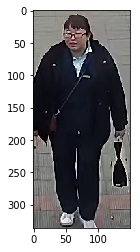

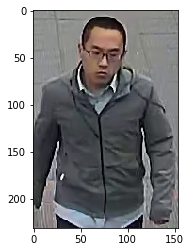

In [43]:
s1 = face_recognition.load_image_file("/data/ftian/xdrive/videos/img/search1.png")
s2 = face_recognition.load_image_file("/data/ftian/xdrive/videos/img/search2.png")

plt.imshow(s1)
plt.show()
plt.imshow(s2)
plt.show()


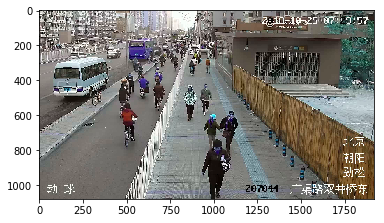

In [44]:
vc = cv2.VideoCapture("/data/ftian/xdrive/videos/short/bj-2.mp4")
ok, frame = vc.read()
plt.imshow(frame)
plt.show()
vc.release()

In [45]:

# We have setup xdrive to ls image files.   Let's see the files, 
xt = dg.xtable.fromQuery(con, '''
select count(*) from (select dir, basename from 
videofiles where basename like '%mp4') tmpt
''')

print(xt.show())

+---------+
|   count |
|---------|
|      62 |
+---------+


In [46]:
xt = dg.xtable.fromQuery(con, '''
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as frame, 
dg_utils.transducer_column_text(3) as tag, 
dg_utils.transducer_column_float4(4) as score,
dg_utils.transducer_column_float4(5) as llx, 
dg_utils.transducer_column_float4(6) as lly, 
dg_utils.transducer_column_float4(7) as urx, 
dg_utils.transducer_column_float4(8) as ury, 
dg_utils.transducer_column_text(9) as img, 
yolov2(), t.*
from (
    select dir || '/' || basename as fn, 0::float4, 0::float4
    from videofiles where basename = 'bj-2.mp4' 
) t
''')

rows = xt.execute()

print("Found {0} objects".format(len(rows)))


Found 22 objects


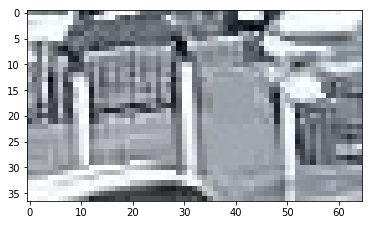

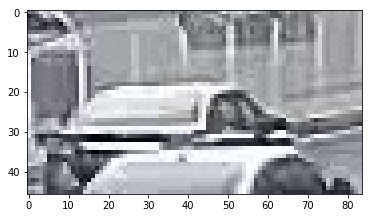

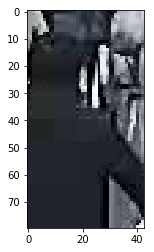

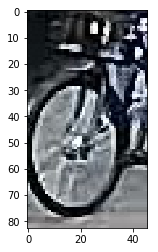

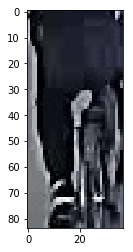

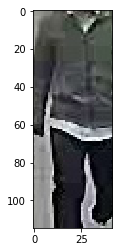

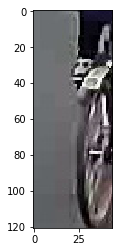

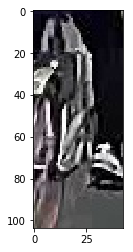

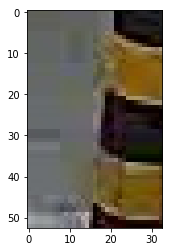

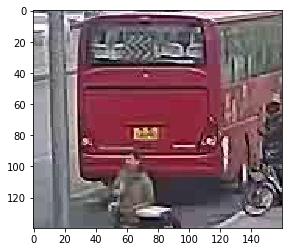

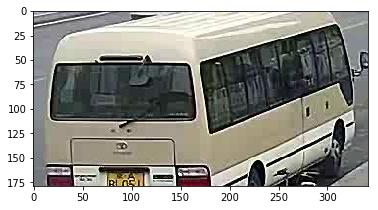

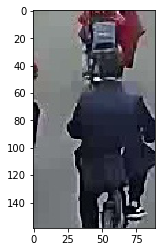

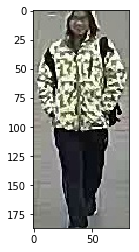

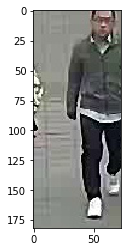

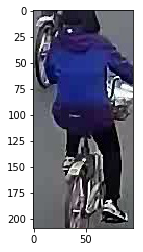

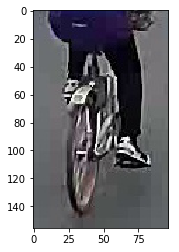

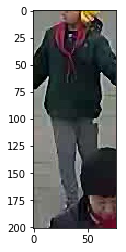

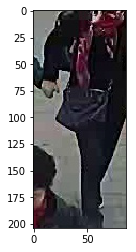

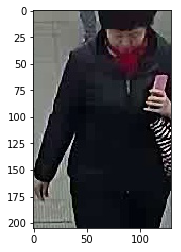

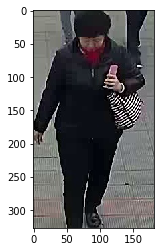

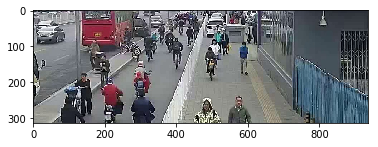

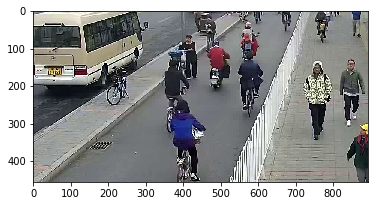

In [47]:
import base64
import numpy as np

for row in rows:
    if row[2] != '':
        img = base64.b64decode(row[8])
        img = np.frombuffer(img, np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        

Maybe it is a good time to look at what we can do with YOLO.
The following sql, will turn the video streams into a structured event stream.
```
-- explain analyze 
drop table videoevt;

create table videoevt as
select filename, frame, tag, score, llx, lly, urx, ury, img
from (
select 
dg_utils.transducer_column_text(1) as filename,
dg_utils.transducer_column_int4(2) as frame, 
dg_utils.transducer_column_text(3) as tag, 
dg_utils.transducer_column_float4(4) as score,
dg_utils.transducer_column_float4(5) as llx, 
dg_utils.transducer_column_float4(6) as lly, 
dg_utils.transducer_column_float4(7) as urx, 
dg_utils.transducer_column_float4(8) as ury, 
dg_utils.transducer_column_text(9) as img, 
yolov2(), t.*
from (
    select dir || '/' || basename as fn, 0::float4, 30::float4
    from videofiles 
) t
) tmpt
;
```

Next, we can run a image/face recognition,
```
create table facext2 as
select trfilename, trframe, trtag, trscore, 
        trllx, trlly, trurx, trury, 
        s1, s2
from (
select 
dg_utils.transducer_column_text(1) as trfilename,
dg_utils.transducer_column_int4(2) as trframe, 
dg_utils.transducer_column_text(3) as trtag, 
dg_utils.transducer_column_float4(4) as trscore,
dg_utils.transducer_column_float4(5) as trllx, 
dg_utils.transducer_column_float4(6) as trlly, 
dg_utils.transducer_column_float4(7) as trurx, 
dg_utils.transducer_column_float4(8) as trury, 
dg_utils.transducer_column_float4(9) as s1, 
dg_utils.transducer_column_float4(10) as s2,
facedist(), vt.*
from (
    select * from videoevt
    where tag = 'person'
) vt 
) tmpt;
```

In [48]:
matchs1 = dg.xtable.fromQuery(con, '''
select * from facext2 order by s1 limit 10
'''
)
print(matchs1.show())

matchs2 = dg.xtable.fromQuery(con, '''
select * from facext2 order by s2 limit 10
'''
)
print(matchs2.show())


+-------------------------------------------+-----------+---------+-----------+---------+---------+---------+---------+----------+----------+
| trfilename                                |   trframe | trtag   |   trscore |   trllx |   trlly |   trurx |   trury |       s1 |       s2 |
|-------------------------------------------+-----------+---------+-----------+---------+---------+---------+---------+----------+----------|
| /data/ftian/xdrive/videos/short/bj-3.mp4  |       276 | person  |  0.581465 |     936 |    1079 |    1116 |     972 | 0.323471 | 0.563991 |
| /data/ftian/xdrive/videos/short/bj-29.mp4 |       576 | person  |  0.577089 |     919 |    1079 |    1121 |     976 | 0.38903  | 0.572847 |
| /data/ftian/xdrive/videos/short/bj-2.mp4  |       576 | person  |  0.700064 |    1003 |    1016 |    1149 |     714 | 0.396928 | 0.545958 |
| /data/ftian/xdrive/videos/short/bj-3.mp4  |       601 | person  |  0.430959 |      61 |     854 |     168 |     673 | 0.408904 | 0.611373 |
| /dat

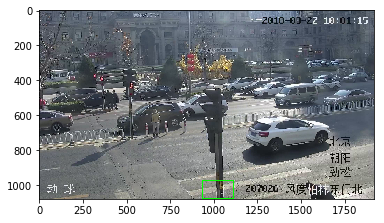

In [52]:
vc = cv2.VideoCapture("/data/ftian/xdrive/videos/short/bj-51.mp4")
vc.set(1, 526)
ok, frame = vc.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
llx = 936
lly = 1079
urx = 1116
ury = 972
cv2.rectangle(frame, (llx, ury), (urx, lly), (0, 255, 0), 3)
plt.imshow(frame)
plt.show()
vc.release()

In [51]:
cars = dg.xtable.fromQuery(con, '''
select filename, frame, count(*) from videoevt where tag = 'car' 
group by filename, frame
order by count(*) desc
limit 10
''')

print (cars.show())


+-------------------------------------------+---------+---------+
| filename                                  |   frame |   count |
|-------------------------------------------+---------+---------|
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     526 |      37 |
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     651 |      35 |
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     476 |      32 |
| /data/ftian/xdrive/videos/short/bj-46.mp4 |     301 |      31 |
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     101 |      31 |
| /data/ftian/xdrive/videos/short/bj-46.mp4 |     676 |      31 |
| /data/ftian/xdrive/videos/short/bj-46.mp4 |     526 |      31 |
| /data/ftian/xdrive/videos/short/bj-46.mp4 |     501 |      31 |
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     126 |      30 |
| /data/ftian/xdrive/videos/short/bj-51.mp4 |     726 |      30 |
+-------------------------------------------+---------+---------+
